# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Helper functions

In [2]:
def plot_all_benchmark_scores(scores_df):
    """
    Plot all scores from all benchmarks on a single graph.
    Each benchmark's scores are plotted as scatter points connected by lines.
    """
    plt.figure(figsize=(10, 6))

    # Group by benchmark_id and plot each one
    for bench_id, group in scores_df.groupby("benchmark_id"):
        group = group.sort_values("date")
        plt.scatter(group["date"], group["performance"], alpha=0.6, label=f"Benchmark {bench_id}")
        plt.plot(group["date"], group["performance"], linestyle="--", alpha=0.6)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title("Performance on All Benchmarks Over Time")
    plt.grid(True)
    # plt.legend()
    plt.show()

def plot_benchmark_scores(benchmark_id, scores_df):
    """
    Plot scores on a specified benchmark over time.
    """
    bench_scores = scores_df[scores_df['benchmark_id'] == benchmark_id].copy()
    if bench_scores.empty:
        print(f"No scores available for benchmark_id {benchmark_id}.")
        return
    bench_scores.sort_values("model_times", inplace=True)

    plt.figure(figsize=(8, 5))
    plt.scatter(bench_scores['date'], bench_scores['performance'], color="blue", label="Scores", alpha=0.7)
    plt.plot(bench_scores['date'], bench_scores['performance'], linestyle="--", color="blue", alpha=0.7)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title(f"Performance on Benchmark {benchmark_id} Over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

In [3]:
# -------------------------
# Data generation
# -------------------------

def generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.05,
    noise_std_bench=0.05,  # NEW: noise for benchmark difficulties
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=3,
    max_alpha=10,
    frac_accelerate_models=1
):
    np.random.seed(42)

    # Models
    model_times = np.sort(
        np.random.uniform(time_range_start, time_range_end, num_models)
    )
    slope_model = elo_change / (time_range_end - time_range_start)

    # Decide which post-cutoff models accelerate
    random_draws     = np.random.rand(num_models)
    accelerate_mask  = (model_times >= cutoff_year) & (random_draws < frac_accelerate_models)

    # Compute capabilities
    model_capabilities = (
        base_model
        + np.where(
            accelerate_mask,
            # accelerated: baseline until cutoff, then faster slope
            slope_model * (cutoff_year - time_range_start) +
            speedup_factor_model * slope_model * (model_times - cutoff_year),
            # normal: same slope the whole time
            slope_model * (model_times - time_range_start)
        )
        + np.random.normal(0, noise_std_model, num_models)
    )
    models = pd.DataFrame({
        'model_id': np.arange(num_models),
        'date': model_times,
        'model_capabilities': model_capabilities,
        'accelerated': accelerate_mask
    })

    # Benchmarks
    benchmark_times = np.random.uniform(
        time_range_start, time_range_end, num_benchmarks
    )
    slope_bench = elo_change / (time_range_end - time_range_start)
    benchmark_difficulties = (
        base_bench
        + np.where(
            benchmark_times < cutoff_year,
            slope_bench * (benchmark_times - time_range_start),
            slope_bench * (cutoff_year - time_range_start)
              + 1 * slope_bench * (benchmark_times - cutoff_year)
        )
        + np.random.normal(0, noise_std_bench, num_benchmarks)  # NEW: add noise to difficulties
    )
    benchmark_progress_slopes = np.random.uniform(
        min_alpha, max_alpha, num_benchmarks
    )
    benchmarks = pd.DataFrame({
        'benchmark_id': np.arange(num_benchmarks),
        'benchmark_release_date': benchmark_times,
        'benchmark_difficulties': benchmark_difficulties,
        'benchmark_progress_slopes': benchmark_progress_slopes
    })

    def logistic(x):
        return 1 / (1 + np.exp(-x))

    # Scores
    scores = []
    for _, m in models.iterrows():
        raw = logistic(
            benchmarks['benchmark_progress_slopes']
            * (m['model_capabilities'] - benchmarks['benchmark_difficulties'])
        )
        mask = (raw >= saturation_level) & (raw <= 1 - saturation_level)
        for b_idx, s in zip(benchmarks['benchmark_id'][mask], raw[mask]):
            if np.random.rand() < frac_eval:
                noisy = np.clip(s + np.random.normal(0, error_std), 0, 1 - saturation_level)
                scores.append({
                    'model_id': m['model_id'],
                    'benchmark_id': b_idx,
                    'date': m['date'],
                    'performance': noisy
                })
    df_scores = pd.DataFrame(scores)

    return models, benchmarks, df_scores

In [4]:
from scipy.optimize import least_squares

def estimated_capabilities(models, benchmarks, df):
  # -----------------------------
  # 1) Identify valid/invalid models
  # -----------------------------
  valid_model_ids = sorted(df["model_id"].unique())  # all models with data
  skipped_model_ids = set(models["model_id"]) - set(valid_model_ids)
  print("Skipping models (no data):", skipped_model_ids)

  # -----------------------------
  # 2) Create a mapping for valid models (without re-indexing original DataFrame)
  # -----------------------------
  # Map each valid model's original id to a parameter index for fitting.
  model_id_to_fit_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
  num_valid_models = len(valid_model_ids)
  num_benchmarks = benchmarks.shape[0]  # Assuming benchmark ids are 0, 1, ..., (num_benchmarks-1)

  # -----------------------------
  # 3) Prepare arrays for fitting
  # -----------------------------
  # Convert the model_ids in scores_df using the mapping (for valid models only)
  model_idx_for_data = np.array([model_id_to_fit_idx[m] for m in df["model_id"]])

  # Ensure benchmark_ids are integers
  benchmark_ids_for_data = df["benchmark_id"].values.astype(int)
  anchor_idx        = 0                       # first element of that array
  observed_scores = df["performance"].values

  # -----------------------------
  # 4) Define logistic and residual functions
  # -----------------------------
  def logistic(x):
      return 1 / (1 + np.exp(-x))

  def residuals(params, model_idx_for_data, benchmark_ids_for_data, observed_scores):
      # Unpack parameters
      C = params[:num_valid_models]  # capabilities for valid models
      D = params[num_valid_models:num_valid_models + num_benchmarks]  # benchmark difficulties
      alpha = params[num_valid_models + num_benchmarks:]  # benchmark slopes

      # Use the mapped indices
      c_vals = C[model_idx_for_data]
      d_vals = D[benchmark_ids_for_data]
      alpha_vals = alpha[benchmark_ids_for_data]

      # Compute predicted logistic scores
      preds = logistic(alpha_vals * (c_vals - d_vals))
      return preds - observed_scores

  # -----------------------------
  # 5) Set initial guesses
  # -----------------------------
  initial_C = np.zeros(num_valid_models)
  initial_D = np.zeros(num_benchmarks)
  initial_alpha = np.ones(num_benchmarks)
  initial_params = np.concatenate([initial_C, initial_D, initial_alpha])

  # -----------------------------
  # 6) Fit only the valid models
  # -----------------------------
  result = least_squares(
      residuals,
      initial_params,
      args=(model_idx_for_data, benchmark_ids_for_data, observed_scores)
  )

  estimated_params = result.x
  estimated_C = estimated_params[:num_valid_models]
  estimated_D = estimated_params[num_valid_models:num_valid_models + num_benchmarks]
  estimated_alpha = estimated_params[num_valid_models + num_benchmarks:]

  # -----------------------------
  # 7) Map the fitted capabilities back to the original model IDs (for valid models only)
  # -----------------------------
  # 7a) Build a DataFrame of unaligned C’s for each valid model_id:
  fitted_C_df = pd.DataFrame({
      "model_id": valid_model_ids,
      "unaligned_C": estimated_C
  })

  # 7b) Pull in the true capabilities and date from your original models DF:
  #     this automatically lines everything up by model_id
  meta = models[["model_id", "model_capabilities", "date"]]
  fitted_C_df = fitted_C_df.merge(meta, on="model_id", how="left")

  # 7c) Compute the alignment transform:
  a, b = np.polyfit(
      fitted_C_df["unaligned_C"].values,
      fitted_C_df["model_capabilities"].values,
      1
  )
  print(f"Alignment transform: C_aligned = {a:.3f} * C_fit + {b:.3f}")

  # 7d) Apply it to get your final estimated_capability:
  fitted_C_df["estimated_capability"] = (
      a * fitted_C_df["unaligned_C"] + b
  )

  # 7e) Drop any extra cols if you only want model_id, date, estimated_capability:
  return fitted_C_df #[["model_id", "date", "estimated_capability"]]

# Generating synthetic data

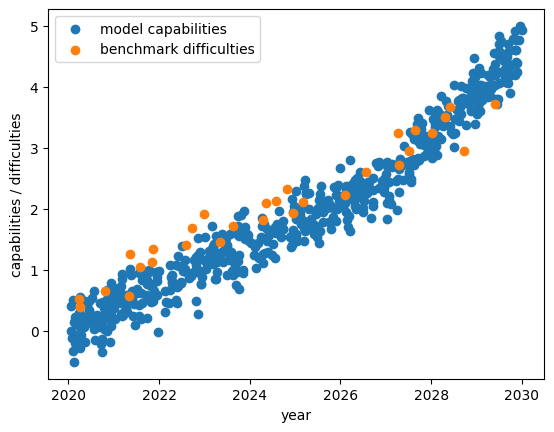

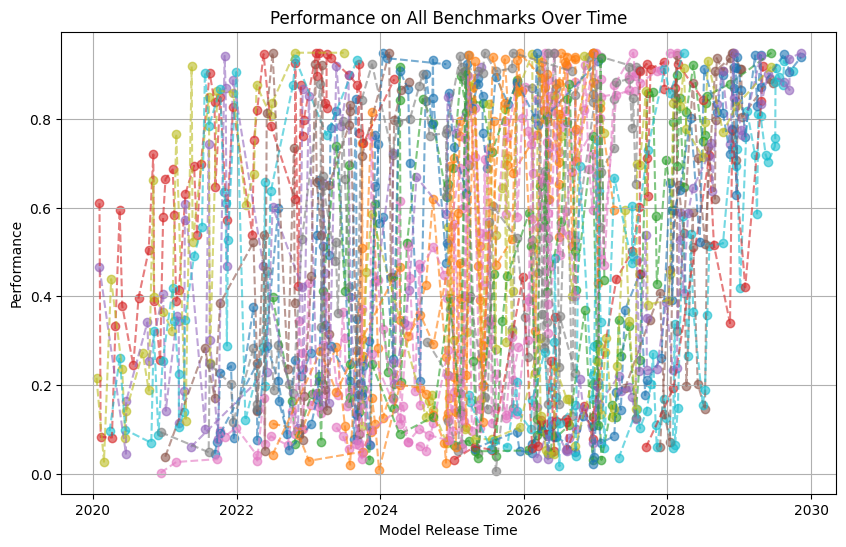

In [5]:
models_broad, benchmarks_broad, df_broad = generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.25,
    noise_std_bench=0.25,
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=2.5,
    max_alpha=10,
    frac_accelerate_models=1
)

plt.scatter(models_broad["date"], models_broad["model_capabilities"], label="model capabilities")
plt.scatter(benchmarks_broad["benchmark_release_date"], benchmarks_broad["benchmark_difficulties"], label="benchmark difficulties")
plt.legend()
plt.xlabel("year")
plt.ylabel("capabilities / difficulties")
plt.show()

plot_all_benchmark_scores(df_broad)

In [8]:
df_broad_est = estimated_capabilities(models_broad, benchmarks_broad, df_broad)
df_broad_est

Skipping models (no data): {512, 1, 2, 5, 6, 7, 8, 519, 10, 11, 12, 525, 14, 15, 17, 529, 19, 20, 531, 22, 23, 24, 532, 26, 536, 537, 29, 538, 539, 32, 33, 541, 543, 36, 37, 544, 39, 40, 41, 548, 43, 552, 45, 46, 47, 48, 49, 50, 554, 52, 556, 54, 561, 56, 57, 563, 567, 568, 61, 62, 63, 569, 65, 574, 67, 575, 576, 70, 577, 578, 579, 580, 75, 76, 581, 584, 585, 80, 587, 588, 589, 84, 85, 86, 591, 592, 89, 593, 594, 595, 596, 94, 598, 599, 98, 99, 101, 103, 106, 109, 116, 122, 131, 133, 137, 141, 149, 151, 152, 160, 172, 205, 218, 239, 557, 268, 281, 306, 320, 332, 341, 407, 435, 442, 443, 597, 464, 493, 506, 509}
Alignment transform: C_aligned = 0.847 * C_fit + 1.693


,model_id,unaligned_C,model_capabilities,date,estimated_capability
0,0,-1.551572,0.409097,2020.050616,0.378960
1,3,-1.413985,0.502479,2020.091971,0.495464
2,4,-2.481033,-0.324072,2020.108377,-0.408072
3,9,-1.946245,0.231187,2020.154566,0.044767
4,13,-1.685854,0.299566,2020.232719,0.265255
...,...,...,...,...,...
465,573,2.823707,4.149335,2029.624473,4.083779
466,582,2.694194,4.053947,2029.699099,3.974113
467,583,3.018091,4.290986,2029.699144,4.248376
468,586,3.206044,4.350093,2029.743948,4.407527


# Detect acceleration?

In [8]:
def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    # First segment: y = slope1 * x + intercept1 (for x < breakpoint)
    # Second segment: continuous at breakpoint with slope2
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear_improved(x, y, num_breaks=30):
    """Fit a breakpoint by scanning candidate bps and optimizing."""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]

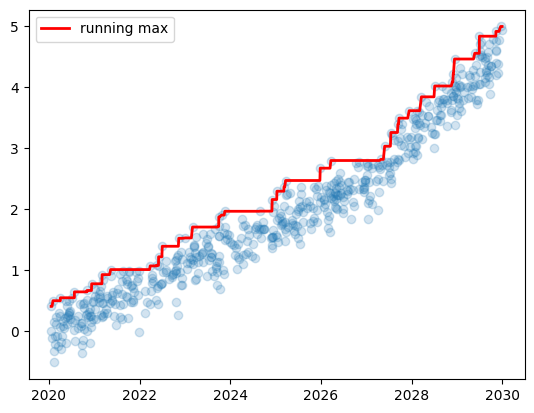

In [ ]:
df = models_broad.sort_values("date").copy()
df["running_max"] = df.model_capabilities.cummax()

plt.scatter(df.date, df.model_capabilities, alpha=0.2)
plt.plot(df.date, df.running_max, "r-", lw=2, label="running max")
plt.legend()
plt.show()

Breakpoint at year = 2027.320
Pre‐break slope = 0.364, post‐break slope = 0.736
R² = 0.9944


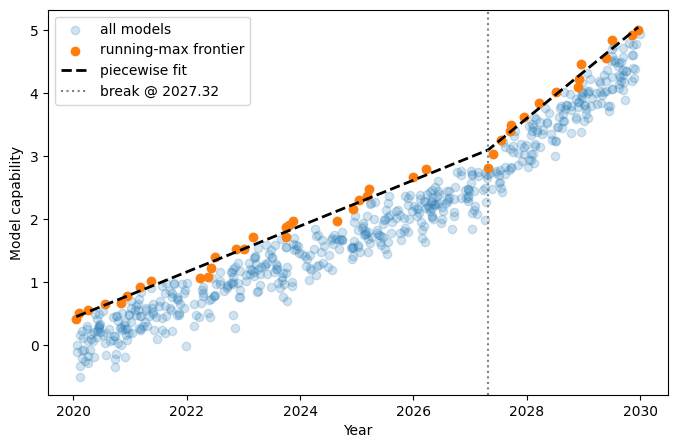

In [9]:
# --- 1) compute running‐max frontier ---

df = models_broad.sort_values("date").copy()
df["running_max"] = df["model_capabilities"].cummax()

frontier_df = df[df["model_capabilities"] == df["running_max"]]

# x = float‐year, y = capability
x = frontier_df["date"].values
y = frontier_df["model_capabilities"].values

# --- 2) fit piecewise linear ---

params, best_r2 = fit_piecewise_linear_improved(x, y, num_breaks=50)
slope1, intercept1, slope2, bp = params

print(f"Breakpoint at year = {bp:.3f}")
print(f"Pre‐break slope = {slope1:.3f}, post‐break slope = {slope2:.3f}")
print(f"R² = {best_r2:.4f}")

# --- 3) plot everything ---

# dense x for smooth plot
x_fine = np.linspace(x.min(), x.max(), 400)
y_fine = piecewise_linear(x_fine, *params)

plt.figure(figsize=(8,5))
# all model points
plt.scatter(df["date"], df["model_capabilities"],
            alpha=0.2, label="all models")
# frontier points
plt.scatter(frontier_df["date"], frontier_df["model_capabilities"],
            color="C1", label="running‐max frontier")
# piecewise fit
plt.plot(x_fine, y_fine, "k--", lw=2, label="piecewise fit")
plt.axvline(bp, color="gray", linestyle=":", label=f"break @ {bp:.2f}")
plt.xlabel("Year")
plt.ylabel("Model capability")
plt.legend()
plt.show()

In [ ]:
# Detection latency simulation (vary benchmarks/year, models/year, acceleration rate)
import itertools

# Core detection routine using existing helpers: generate_data, estimated_capabilities, fit_piecewise_linear_improved

def compute_detection_time(models_df, benchmarks_df, scores_df, cutoff_year, required_ratio=2.0, 
                           min_r2=0.6, min_gap_years=0.0):
    """
    Return (detected: bool, bp, slope1, slope2, r2, years_to_detect, models_to_detect, benchmarks_to_detect, t_detect)
    - years_to_detect is relative to cutoff_year
    - models_to_detect/benchmarks_to_detect count releases between cutoff_year and detection time inclusive
    Detection based on piecewise-linear slope ratio >= required_ratio and breakpoint >= cutoff_year + min_gap_years
    """
    # Estimate capabilities from currently available scores
    df_est = estimated_capabilities(models_df, benchmarks_df, scores_df)
    df_est_sorted = df_est.sort_values("date").copy()
    if df_est_sorted.empty:
        return (False, None, None, None, None, None, None, None, None)

    # Running max frontier to reduce noise
    df_est_sorted["frontier"] = df_est_sorted["estimated_capability"].cummax()

    xs = df_est_sorted["date"].values
    ys = df_est_sorted["frontier"].values

    params, r2 = fit_piecewise_linear_improved(xs, ys, num_breaks=30)
    if params is None:
        return (False, None, None, None, None, None, None, None, None)

    slope1, intercept1, slope2, bp = params
    ratio = slope2 / slope1 if slope1 not in (0, None) else np.inf

    detected = (r2 is not None and r2 >= min_r2 and ratio >= required_ratio and bp >= cutoff_year + min_gap_years)

    # If detected, set detection time to the latest model date used
    t_detect = xs.max()
    years_to_detect = (t_detect - cutoff_year) if detected else None

    # Count releases from cutoff to detection time
    if detected:
        models_to_detect = int(((models_df["date"] > cutoff_year) & (models_df["date"] <= t_detect)).sum())
        benchmarks_to_detect = int(((benchmarks_df["benchmark_release_date"] > cutoff_year) & (benchmarks_df["benchmark_release_date"] <= t_detect)).sum())
    else:
        models_to_detect = None
        benchmarks_to_detect = None

    return (detected, bp, slope1, slope2, r2, years_to_detect, models_to_detect, benchmarks_to_detect, t_detect)


def detect_when_enough_data(models_df, benchmarks_df, scores_df, cutoff_year, required_ratio=2.0,
                            check_every=5, min_r2=0.6, min_gap_years=0.0):
    """
    Incrementally reveal scores over time (by model release date) and return detection metrics
    when a 2x (or required_ratio) speedup is detected.
    """
    # Unique model release times after cutoff
    post_cutoff_times = np.sort(models_df.loc[models_df["date"] > cutoff_year, "date"].values)
    if post_cutoff_times.size == 0:
        return {
            "detected": False,
            "years_to_detect": None,
            "models_to_detect": None,
            "benchmarks_to_detect": None,
            "detection_time": None,
            "ratio": None,
            "bp": None,
            "slope1": None,
            "slope2": None,
            "r2": None,
        }

    # Reveal scores up to each time threshold
    for i, t in enumerate(post_cutoff_times, start=1):
        if i % check_every != 0 and i != post_cutoff_times.size:
            continue

        cur_scores = scores_df[scores_df["date"] <= t].copy()
        if cur_scores.shape[0] < 50:  # ensure enough observations
            continue

        detected, bp, m1, m2, r2, years_to_detect, models_to_detect, benchmarks_to_detect, t_detect = compute_detection_time(
            models_df, benchmarks_df, cur_scores, cutoff_year,
            required_ratio=required_ratio, min_r2=min_r2, min_gap_years=min_gap_years
        )
        if detected:
            return {
                "detected": True,
                "years_to_detect": years_to_detect,
                "models_to_detect": models_to_detect,
                "benchmarks_to_detect": benchmarks_to_detect,
                "detection_time": t_detect,
                "ratio": (m2 / m1) if (m1 is not None and m1 != 0) else np.inf,
                "bp": bp,
                "slope1": m1,
                "slope2": m2,
                "r2": r2,
            }

    # If loop completes without detection
    return {
        "detected": False,
        "years_to_detect": None,
        "models_to_detect": None,
        "benchmarks_to_detect": None,
        "detection_time": None,
        "ratio": None,
        "bp": None,
        "slope1": None,
        "slope2": None,
        "r2": None,
    }


def run_single_simulation(models_per_year, benchmarks_per_year, accel_factor, *,
                          time_range_start=2025, horizon_years=10, cutoff_year=None,
                          frac_eval=0.25, error_std=0.025, elo_change=3.5,
                          base_model=0.0, noise_std_model=0.25, noise_std_bench=0.25,
                          base_bench=0.5, saturation_level=0.05, min_alpha=2.5, max_alpha=10.0,
                          frac_accelerate_models=1.0, required_ratio=2.0, check_every=5,
                          min_r2=0.6, min_gap_years=0.0, random_seed=None):
    """
    Generate synthetic data with specified densities and acceleration, then compute detection latency.
    Returns a dict of metrics.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    time_range_end = time_range_start + horizon_years
    if cutoff_year is None:
        # place cutoff 30% into the horizon to ensure enough post-cutoff data
        cutoff_year = time_range_start + 0.3 * horizon_years

    num_models = max(10, int(models_per_year * horizon_years))
    num_benchmarks = max(4, int(benchmarks_per_year * horizon_years))

    models_df, benchmarks_df, scores_df = generate_data(
        num_models=num_models,
        num_benchmarks=num_benchmarks,
        speedup_factor_model=accel_factor,
        time_range_start=time_range_start,
        time_range_end=time_range_end,
        cutoff_year=cutoff_year,
        frac_eval=frac_eval,
        error_std=error_std,
        elo_change=elo_change,
        base_model=base_model,
        noise_std_model=noise_std_model,
        noise_std_bench=noise_std_bench,
        base_bench=base_bench,
        saturation_level=saturation_level,
        min_alpha=min_alpha,
        max_alpha=max_alpha,
        frac_accelerate_models=frac_accelerate_models,
    )

    metrics = detect_when_enough_data(
        models_df, benchmarks_df, scores_df, cutoff_year,
        required_ratio=required_ratio, check_every=check_every,
        min_r2=min_r2, min_gap_years=min_gap_years
    )

    metrics.update({
        "models_per_year": models_per_year,
        "benchmarks_per_year": benchmarks_per_year,
        "accel_factor": accel_factor,
        "cutoff_year": cutoff_year,
        "horizon_years": horizon_years,
    })
    return metrics


def run_grid(models_per_year_list, benchmarks_per_year_list, accel_factors, *,
             horizon_years=10, cutoff_year=None, n_sims=3, random_seed_base=123,
             required_ratio=2.0, check_every=5, min_r2=0.6, min_gap_years=0.0):
    results = []
    for (mpy, bpy, af) in itertools.product(models_per_year_list, benchmarks_per_year_list, accel_factors):
        agg = []
        for s in range(n_sims):
            sim_res = run_single_simulation(
                models_per_year=mpy,
                benchmarks_per_year=bpy,
                accel_factor=af,
                horizon_years=horizon_years,
                cutoff_year=cutoff_year,
                required_ratio=required_ratio,
                check_every=check_every,
                min_r2=min_r2,
                min_gap_years=min_gap_years,
                random_seed=random_seed_base + s,
            )
            agg.append(sim_res)
        # Aggregate over sims
        def mean_or_none(vals):
            vals = [v for v in vals if v is not None]
            return (np.mean(vals) if len(vals) > 0 else None)

        detected_any = any(a["detected"] for a in agg)
        results.append({
            "models_per_year": mpy,
            "benchmarks_per_year": bpy,
            "accel_factor": af,
            "detected_share": np.mean([1 if a["detected"] else 0 for a in agg]),
            "years_to_detect_mean": mean_or_none([a["years_to_detect"] for a in agg]),
            "models_to_detect_mean": mean_or_none([a["models_to_detect"] for a in agg]),
            "benchmarks_to_detect_mean": mean_or_none([a["benchmarks_to_detect"] for a in agg]),
        })
    return pd.DataFrame(results)

# Example usage: vary densities and acceleration; measure time and releases to detect 2x
models_per_year_list = [5, 10, 15]          # e.g., semiannual, monthly, biweekly model releases
benchmarks_per_year_list = [1, 3, 10]      # e.g., benchmark updates per year
accel_factors = [3, 4, 5]             # rate of acceleration; we detect for >= 2x

res_df = run_grid(
    models_per_year_list,
    benchmarks_per_year_list,
    accel_factors,
    horizon_years=3,
    cutoff_year=2027,
    n_sims=1,
    required_ratio=2.0,
    check_every=5,
    min_r2=0.6,
)


Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 37, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.354 * C_fit + 1.559
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.250 * C_fit + 1.475
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.250 * C_fit + 1.475
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.250 * C_fit + 1.475
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.337 * C_fit + 1.414
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44}
Alignment transform: C_aligned = 0.337 * C_fit + 1.414
Skipping models (no data): {0, 1, 4, 5, 6, 7, 10, 11, 13, 17, 26, 36, 37, 

,models_per_year,benchmarks_per_year,accel_factor,detected_share,years_to_detect_mean,models_to_detect_mean,benchmarks_to_detect_mean
0,5,1,3,0.0,NaN,NaN,NaN
3,5,3,3,0.0,NaN,NaN,NaN
6,5,10,3,0.0,NaN,NaN,NaN
9,10,1,3,0.0,NaN,NaN,NaN
12,10,3,3,0.0,NaN,NaN,NaN
15,10,10,3,0.0,NaN,NaN,NaN
18,15,1,3,0.0,NaN,NaN,NaN
21,15,3,3,0.0,NaN,NaN,NaN
24,15,10,3,1.0,0.355528,4.0,5.0
1,5,1,4,0.0,NaN,NaN,NaN


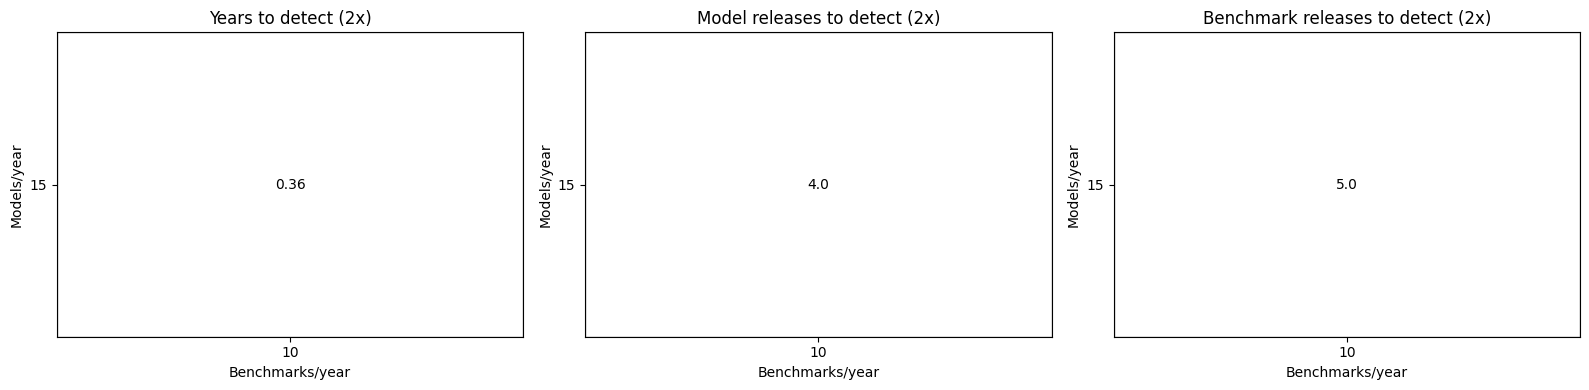

/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_80309/1325595420.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, ncols)
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_80309/1325595420.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(nrows, 0)
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_80309/1325595420.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, ncols)
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_80309/1325595420.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(nrows, 0)
/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_80309/1325595420.py:13: UserWarning: Attempting t

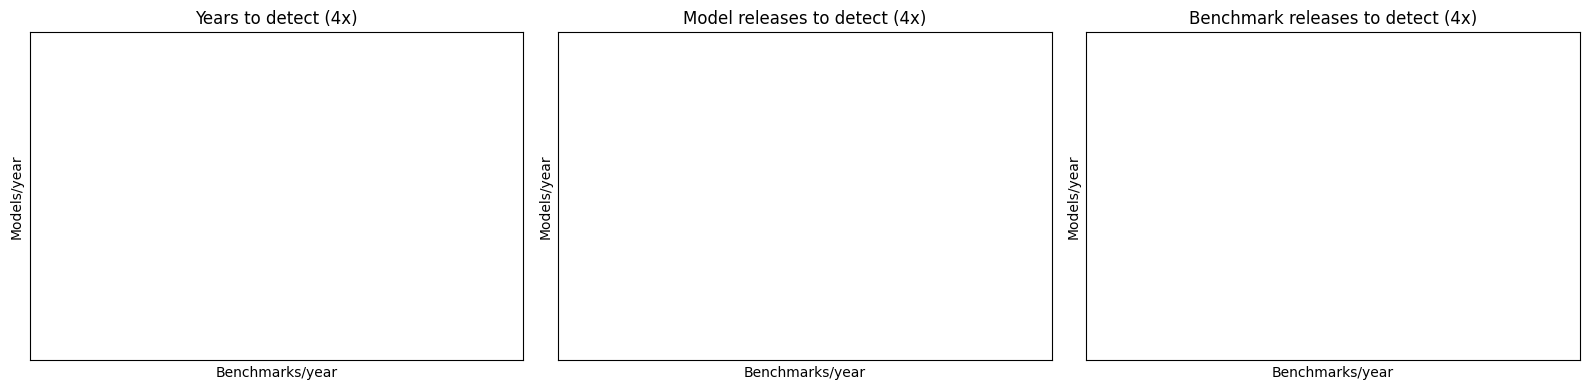

In [36]:
display(res_df.sort_values(["accel_factor", "models_per_year", "benchmarks_per_year"]))

# Annotated grids for accel_factor == 2x and 4x

def draw_annotated_grid(ax, mat, row_labels, col_labels, title, fmt="{:.2f}"):
    nrows, ncols = mat.shape
    for i in range(nrows):
        for j in range(ncols):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="gray"))
            val = mat[i, j]
            if val is not None and not np.isnan(val):
                ax.text(j + 0.5, i + 0.5, fmt.format(val), ha="center", va="center")
    ax.set_xlim(0, ncols)
    ax.set_ylim(nrows, 0)
    ax.set_xticks(np.arange(ncols) + 0.5)
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel("Benchmarks/year")
    ax.set_ylabel("Models/year")
    ax.set_title(title)

# 2x
subset2 = res_df[res_df["accel_factor"].isin([3, 3.0])].copy()
if not subset2.empty:
    pivot2_years = subset2.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="years_to_detect_mean", aggfunc="mean")
    pivot2_models = subset2.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="models_to_detect_mean", aggfunc="mean")
    pivot2_bench  = subset2.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="benchmarks_to_detect_mean", aggfunc="mean")

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    draw_annotated_grid(axes[0], pivot2_years.values, list(pivot2_years.index), list(pivot2_years.columns), "Years to detect (2x)", fmt="{:.2f}")
    draw_annotated_grid(axes[1], pivot2_models.values, list(pivot2_models.index), list(pivot2_models.columns), "Model releases to detect (2x)", fmt="{:.1f}")
    draw_annotated_grid(axes[2], pivot2_bench.values, list(pivot2_bench.index), list(pivot2_bench.columns), "Benchmark releases to detect (2x)", fmt="{:.1f}")
    plt.tight_layout()
    plt.show()

# 4x
subset4 = res_df[res_df["accel_factor"].isin([4, 4.0])].copy()
if not subset4.empty:
    pivot4_years = subset4.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="years_to_detect_mean", aggfunc="mean")
    pivot4_models = subset4.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="models_to_detect_mean", aggfunc="mean")
    pivot4_bench  = subset4.pivot_table(index="models_per_year", columns="benchmarks_per_year", values="benchmarks_to_detect_mean", aggfunc="mean")

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    draw_annotated_grid(axes[0], pivot4_years.values, list(pivot4_years.index), list(pivot4_years.columns), "Years to detect (4x)", fmt="{:.2f}")
    draw_annotated_grid(axes[1], pivot4_models.values, list(pivot4_models.index), list(pivot4_models.columns), "Model releases to detect (4x)", fmt="{:.1f}")
    draw_annotated_grid(axes[2], pivot4_bench.values, list(pivot4_bench.index), list(pivot4_bench.columns), "Benchmark releases to detect (4x)", fmt="{:.1f}")
    plt.tight_layout()
    plt.show()